## Modeling Survival on the Titanic

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

In [3]:
import plotly as py
import plotly.graph_objs as go

In [4]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

### Read in the titanic dataset

In [6]:
df = pd.read_csv('resources/titanic.csv')
# df = pd.read_csv("https://raw.githubusercontent.com/austinlasseter/plotly_dash_tutorial/master/00%20resources/titanic.csv")
print(df.shape)
df.head()

(712, 8)


,Survived,Pclass,Sex,Age,Fare,Embarked,Name,SibSp
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,1,3,female,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0
3,1,1,female,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,0,3,male,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0


In [7]:
df['Survived'].value_counts()

0    424
1    288
Name: Survived, dtype: int64

### Features

In [8]:
# Make some dummies for sex.
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Sex'])

In [9]:
# Make some dummies Passenger's cabin class
df = pd.get_dummies(df, prefix='Cabin Class', prefix_sep=' ', columns=['Pclass'])

In [10]:
# Make some dummies Passenger's embarkation
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Embarked'])

In [11]:
# Siblings and Spouses
df=df.rename(columns={'SibSp':'Siblings and Spouses'})
df['Siblings and Spouses'].value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: Siblings and Spouses, dtype: int64

In [12]:
# Make some dummies Passenger's embarkation
df = pd.get_dummies(df, prefix='', prefix_sep='sib', columns=['Siblings and Spouses'])

In [13]:
# age requires binning
print(df.Age.describe())
print(df.Age.describe()['25%'])

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
20.0


In [14]:
# Age
bins=[1, 20, 28, 38, 80]
df['age_binned']=pd.cut(df['Age'], bins)
df['age_binned'].value_counts().sort_index()

(1, 20]     165
(20, 28]    183
(28, 38]    174
(38, 80]    176
Name: age_binned, dtype: int64

In [15]:
df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)

,Survived,Age,Fare,Name,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,...,sib0,sib1,sib2,sib3,sib4,sib5,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [16]:
# Name
df['Last Name']=df['Name'].apply(lambda x: x.split(',')[0])
df['First Name']=df['Name'].apply(lambda x: x.split(',')[1])
df['Title']=df['First Name'].apply(lambda x: x.split('.')[0])

In [17]:
# Title
print(df['Title'].value_counts())
df['Mr.']=np.where((df['Title']==' Mr')|(df['Title']==' Master')|(df['Title']==' Ms'), 1, 0) # Ms is actually monsieur
df['Mrs.']=np.where((df['Title']==' Mrs')|(df['Title']==' Mme'), 1, 0)
df['Miss']=np.where((df['Title']==' Miss')|(df['Title']==' Mlle'), 1, 0)
df['VIP']=np.where((df['Mr.']==0)&(df['Mrs.']==0)&(df['Miss']==0), 1, 0)

 Mr              398
 Miss            145
 Mrs             107
 Master           36
 Rev               6
 Dr                6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64


In [18]:
df['VIP'].value_counts()

0    690
1     22
Name: VIP, dtype: int64

In [19]:
# Check for missing values as they will skew the regression
print(df.shape)
df = df.dropna()
print(df.shape)

(712, 29)
(712, 29)


In [20]:
# What are the possible features?
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'female', 'male', 'Cabin Class 1',
       'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown',
       'Southampton', 'sib0', 'sib1', 'sib2', 'sib3', 'sib4', 'sib5',
       'Age (1, 20]', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]',
       'Last Name', 'First Name', 'Title', 'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [22]:
# Turns out that fare doesn't add any significant or meaningful coefficient to the final model, so we're dropping it.
feature_cols=list(df.columns)
for item in ['Survived', 'Fare', 'Cabin Class 1', 'Southampton', 'male', 'Age',  'Age (1, 20]', 'Last Name', 'First Name', 'Title', 'Mr.']:
    feature_cols.remove(item)
print(feature_cols)

['Name', 'female', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown', 'sib0', 'sib1', 'sib2', 'sib3', 'sib4', 'sib5', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP']


In [23]:
df.rename(columns = {'Age (1, 20]':'Age_1_20', 'Age (20, 28]':'Age_20_28'}, inplace = True)
df.rename(columns = {'Age (28, 38]':'Age_28_38', 'Age (38, 80]':'Age_38_80'}, inplace = True)

In [24]:
improved_feature_cols = [ 'female', 'male', 'Cabin Class 1',
       'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown',
       'Southampton', 'sib0', 'sib1', 'sib2', 'sib3', 'sib4', 'sib5',
      'Age_1_20', 'Age_20_28', 'Age_28_38', 'Age_38_80', 
        'Mr.', 'Mrs.', 'Miss', 'VIP']
training_features=df[improved_feature_cols]
training_target=df['Survived']

In [25]:
count_class_0, count_class_1 = df.Survived.value_counts()
# Divide by class
df_class_0 = df[df['Survived'] == 0]
df_class_1 = df[df['Survived'] == 1]

In [26]:
print(count_class_0,count_class_1)

424 288


In [27]:
print('Random over-sampling:')
survive_1_over = df_class_1.sample(count_class_0,random_state=21, replace=True)
survive_1_over = pd.concat([df_class_0, survive_1_over], axis=0)

Random over-sampling:


In [28]:
survive_1_over.Survived.value_counts()

0    424
1    424
Name: Survived, dtype: int64

In [29]:
df=survive_1_over

In [30]:
df['Survived'].value_counts()

0    424
1    424
Name: Survived, dtype: int64

In [31]:
training_features.head(5)

,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,Southampton,sib0,sib1,...,sib4,sib5,Age_1_20,Age_20_28,Age_28_38,Age_38_80,Mr.,Mrs.,Miss,VIP
0,0,1,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
1,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


[0.4602945  0.         0.05212304 0.01167881 0.23445733 0.01132886
 0.00669658 0.01119876 0.0114211  0.01681503 0.0052822  0.04279467
 0.00876859 0.         0.04061042 0.00890412 0.01570421 0.02781465
 0.00784077 0.01234604 0.00728295 0.00663735]


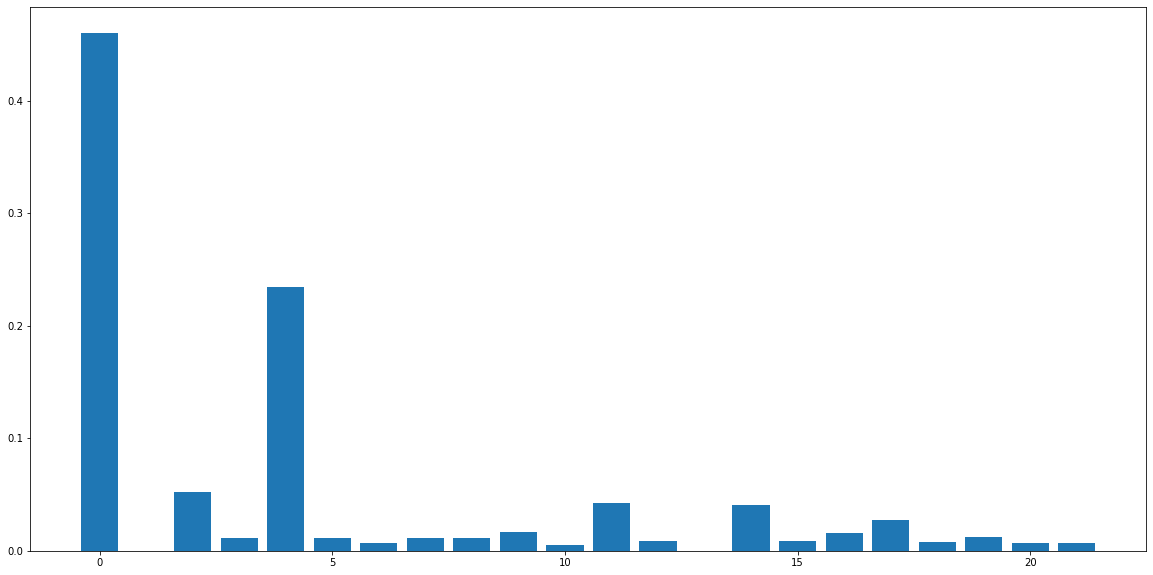

In [32]:
from xgboost import XGBClassifier
from matplotlib import pyplot

plt.figure(figsize=(20,10))

# fit model no training data
model = XGBClassifier()
model.fit(training_features, training_target)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [33]:
feature_importances = pd.DataFrame({'Importance Coef' :model.feature_importances_ , 'Features' : training_features.columns})
feature_importances.nlargest(19, 'Importance Coef')

,Importance Coef,Features
0,0.460295,female
4,0.234457,Cabin Class 3
2,0.052123,Cabin Class 1
11,0.042795,sib3
14,0.040610,Age_1_20
17,0.027815,Age_38_80
9,0.016815,sib1
16,0.015704,Age_28_38
19,0.012346,Mrs.
3,0.011679,Cabin Class 2


### Modeling

In [34]:
# Select our features
X = df[improved_feature_cols]
y = df.Survived

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=21)

In [36]:
import sklearn
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [37]:
# 'Fit' the scaler to our X_train data
std_scaler = std_scaler.fit(X_train.values)
std_scaler

StandardScaler()

In [38]:
X_train_scaled = std_scaler.transform(X_train.values)
X_train_scaled[0]

array([-0.85669022,  0.85669022,  1.56450453, -0.5272734 , -0.98493638,
       -0.4825435 , -0.17693035,  0.52988446,  0.7053189 , -0.58449034,
       -0.18682616, -0.14371515, -0.14371515, -0.05817297, -0.53510191,
       -0.57929749, -0.59747754,  1.7185265 ,  0.88361801, -0.50105374,
       -0.51681139, -0.16652218])

In [39]:
# Use the scaler to transform the dataset
X_test_scaled = std_scaler.transform(X_test.values)
X_test_scaled[0]

array([-0.85669022,  0.85669022,  1.56450453, -0.5272734 , -0.98493638,
       -0.4825435 , -0.17693035,  0.52988446, -1.41779839,  1.71089226,
       -0.18682616, -0.14371515, -0.14371515, -0.05817297, -0.53510191,
       -0.57929749, -0.59747754,  1.7185265 , -1.13171075, -0.50105374,
       -0.51681139,  6.00520607])

In [40]:
X_train.columns

Index(['female', 'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3',
       'Cherbourg', 'Queenstown', 'Southampton', 'sib0', 'sib1', 'sib2',
       'sib3', 'sib4', 'sib5', 'Age_1_20', 'Age_20_28', 'Age_28_38',
       'Age_38_80', 'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [41]:
X_train=X_train_scaled
X_test=X_test_scaled

In [42]:
X_train[0]

array([-0.85669022,  0.85669022,  1.56450453, -0.5272734 , -0.98493638,
       -0.4825435 , -0.17693035,  0.52988446,  0.7053189 , -0.58449034,
       -0.18682616, -0.14371515, -0.14371515, -0.05817297, -0.53510191,
       -0.57929749, -0.59747754,  1.7185265 ,  0.88361801, -0.50105374,
       -0.51681139, -0.16652218])

In [43]:
X_test[0]

array([-0.85669022,  0.85669022,  1.56450453, -0.5272734 , -0.98493638,
       -0.4825435 , -0.17693035,  0.52988446, -1.41779839,  1.71089226,
       -0.18682616, -0.14371515, -0.14371515, -0.05817297, -0.53510191,
       -0.57929749, -0.59747754,  1.7185265 , -1.13171075, -0.50105374,
       -0.51681139,  6.00520607])

In [44]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.6917
Accuracy 0.5490
AUC Score 0.5300


In [45]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.7686
Accuracy 0.7686
AUC Score 0.7701


In [46]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.7955
Accuracy 0.7843
AUC Score 0.7834


In [47]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.8062
Accuracy 0.8039
AUC Score 0.8049


In [48]:
from sklearn.svm import SVC
svc =  SVC(probability = True)
# Fit on the training data
svc_model=svc.fit(X_train, y_train)
# Predict on the testing data
predictions=svc_model.predict(X_test)
probabilities = svc_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_svc=metrics.roc_auc_score(y_test, predictions)
acc_svc = metrics.accuracy_score(y_test, predictions)
f1_svc = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_svc,4))
print('Accuracy', "%.4f" % round(acc_svc,4))
print('AUC Score', "%.4f" % round(auc_svc,4))

F1 Score 0.7893
Accuracy 0.7843
AUC Score 0.7848


In [49]:
from sklearn.svm import SVC
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8487395  0.82352941 0.77310924 0.79661017 0.77118644]
0.8026349522859991


In [110]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81512605 0.82352941 0.75630252 0.77966102 0.77966102]
0.7908560034183165


In [111]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82352941 0.77310924 0.77310924 0.77118644 0.69491525]
0.7671699188149836


In [112]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82352941 0.77310924 0.77310924 0.77118644 0.69491525]
0.7671699188149836


In [65]:
# grid search for optimal hyperparameters
grid_values = {'learning_rate': [1, 2, 3],
               'n_estimators':[50,100,150]}

In [66]:
# grid search for optimal hyperparameters
from xgboost import XGBClassifier
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
xgboost = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
xgboost.fit(X_train,y_train)
predictions=xgboost.predict(X_test)
probabilities = xgboost.predict_proba(X_test)[:,1]
print(xgboost.best_params_)
print(xgboost.best_score_)
auc_xg=metrics.roc_auc_score(y_test, predictions)
acc_xg = metrics.accuracy_score(y_test, predictions)
f1_xg = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_xg,4))
print('Accuracy', "%.4f" % round(acc_xg,4))
print('AUC Score', "%.4f" % round(auc_xg,4))

{'learning_rate': 1, 'n_estimators': 150}
0.8059962968238142
F1 Score 0.7954
Accuracy 0.7922
AUC Score 0.7930


In [67]:
training_features = X_train
training_target = y_train
test_features=X_test
test_target=y_test

In [68]:
# Import Classifiers packages

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import tree

In [69]:
# Using a Dummy Classifier

from sklearn.dummy import DummyClassifier
dummy_baseline = DummyClassifier(strategy="most_frequent")
dummy_baseline.fit(training_features, training_target)

DummyClf = dummy_baseline.score(test_features, test_target)

In [70]:
print(DummyClf)

0.47843137254901963


In [71]:
# Create classifiers

DTModel = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
NBModel = GaussianNB()
LRModel = LogisticRegression(random_state = 0, solver='newton-cg', max_iter=1000)
SVMModel = SVC(kernel = 'linear', random_state = 0)
KSVMModel = SVC(kernel = 'rbf', random_state = 0)
KNNModel = KNeighborsClassifier(n_neighbors = 57)#  , metric = 'minkowski', p = 2
RFModel = RandomForestClassifier( n_estimators=87, random_state=0)
BModel = BaggingClassifier(tree.DecisionTreeClassifier(random_state=0))
ADBModel = AdaBoostClassifier(random_state=0)
GBModel = GradientBoostingClassifier(random_state=0)
ExTrModel = ExtraTreesClassifier(random_state=0)
RCModel = RidgeClassifier(random_state=0)

In [72]:
DTModel.fit(training_features, training_target)
DTPred = DTModel.predict(test_features)
ADT = DTModel.score(test_features, test_target)
auc_dt=metrics.roc_auc_score(test_target, DTPred)
acc_dt = metrics.accuracy_score(test_target, DTPred)
f1_dt = metrics.f1_score(test_target, DTPred)
# Display
print('F1 Score', "%.4f" % round(f1_dt,4))
print('Accuracy', "%.4f" % round(acc_dt,4))
print('AUC Score', "%.4f" % round(auc_dt,4))

F1 Score 0.7922
Accuracy 0.7922
AUC Score 0.7936


In [73]:
KSVMModel.fit(training_features, training_target)
KSVM_pred = KSVMModel.predict(test_features)
ACKSVM= accuracy_score(test_target, KSVM_pred )
auc_ksvm=metrics.roc_auc_score(test_target, KSVM_pred)
acc_ksvm = metrics.accuracy_score(test_target, KSVM_pred)
f1_ksvm = metrics.f1_score(test_target, KSVM_pred)
# Display
print('F1 Score', "%.4f" % round(f1_ksvm,4))
print('Accuracy', "%.4f" % round(acc_ksvm,4))
print('AUC Score', "%.4f" % round(auc_ksvm,4))

F1 Score 0.7893
Accuracy 0.7843
AUC Score 0.7848


In [74]:
BModel.fit(training_features, training_target)
Bagg_pred = BModel.predict(test_features)
ACBagg= accuracy_score(test_target, Bagg_pred )
auc_Bagg=metrics.roc_auc_score(test_target, Bagg_pred)
acc_Bagg = metrics.accuracy_score(test_target, Bagg_pred)
f1_Bagg = metrics.f1_score(test_target, Bagg_pred)
# Display
print('F1 Score', "%.4f" % round(f1_Bagg,4))
print('Accuracy', "%.4f" % round(acc_Bagg,4))
print('AUC Score', "%.4f" % round(auc_Bagg,4))

F1 Score 0.7843
Accuracy 0.7843
AUC Score 0.7858


In [75]:
ADBModel.fit(training_features, training_target)
ADB_pred = ADBModel.predict(test_features)
ACADB = accuracy_score(test_target, ADB_pred )
auc_adb=metrics.roc_auc_score(test_target, ADB_pred)
acc_adb = metrics.accuracy_score(test_target, ADB_pred)
f1_adb = metrics.f1_score(test_target, ADB_pred)
# Display
print('F1 Score', "%.4f" % round(f1_adb,4))
print('Accuracy', "%.4f" % round(acc_adb,4))
print('AUC Score', "%.4f" % round(auc_adb,4))

F1 Score 0.7752
Accuracy 0.7725
AUC Score 0.7735


In [76]:
GBModel.fit(training_features, training_target)
GB_pred = GBModel.predict(test_features)
ACGB= accuracy_score(test_target, GB_pred )
auc_gb=metrics.roc_auc_score(test_target, GB_pred)
acc_gb = metrics.accuracy_score(test_target, GB_pred)
f1_gb = metrics.f1_score(test_target, GB_pred)
# Display
print('F1 Score', "%.4f" % round(f1_gb,4))
print('Accuracy', "%.4f" % round(acc_gb,4))
print('AUC Score', "%.4f" % round(auc_gb,4))

F1 Score 0.7619
Accuracy 0.7647
AUC Score 0.7666


In [77]:
ExTrModel.fit(training_features, training_target)
ExTr_pred = ExTrModel.predict(test_features)
ACExTr= accuracy_score(test_target, ExTr_pred )
auc_extr=metrics.roc_auc_score(test_target, ExTr_pred)
acc_extr = metrics.accuracy_score(test_target, ExTr_pred)
f1_extr = metrics.f1_score(test_target, ExTr_pred)
# Display
print('F1 Score', "%.4f" % round(f1_extr,4))
print('Accuracy', "%.4f" % round(acc_extr,4))
print('AUC Score', "%.4f" % round(auc_extr,4))

F1 Score 0.7686
Accuracy 0.7686
AUC Score 0.7701


In [78]:
# Fit Classifiers
RCModel.fit(training_features, training_target)
RC_pred = RCModel.predict(test_features)
ACRC= accuracy_score(test_target, RC_pred )
auc_rc=metrics.roc_auc_score(test_target, RC_pred)
acc_rc = metrics.accuracy_score(test_target, RC_pred)
f1_rc = metrics.f1_score(test_target, RC_pred)
# Display
print('F1 Score', "%.4f" % round(f1_rc,4))
print('Accuracy', "%.4f" % round(acc_rc,4))
print('AUC Score', "%.4f" % round(auc_rc,4))

F1 Score 0.7541
Accuracy 0.7647
AUC Score 0.7680


In [80]:
print(' The fraction of correct classifications is            : {:.2f}%'.format(DummyClf * 100))
#print(" Logistic Regression Prediction Accuracy               : {:.2f}%".format(ACLR * 100))
#print(" Support Vector Machine Prediction Accuracy            : {:.2f}%".format(ACSVM * 100))
#print(" Artificial Neural Network Prediction Accuracy         : {:.2f}%".format(ACANN * 100))
print(" Ensemble - Ada-Boost Prediction Accuracy              : {:.2f}%".format(ACADB * 100))
#print(" Random Forest Prediction Accuracy                     : {:.2f}%".format(ACRF * 100))
print(" Ridge Classifier Prediction Accuracy                  : {:.2f}%".format(ACRC * 100))
print(" Ensemble - Bagging Prediction Accuracy                : {:.2f}%".format(ACBagg * 100))
print(" Ensemble - Gradient Boosting Prediction Accuracy      : {:.2f}%".format(ACGB * 100))
print(" Ensemble - ExtraTrees Prediction Accuracy             : {:.2f}%".format(ACExTr * 100))
print(" K- Support Vector Machine Prediction Accuracy         : {:.2f}%".format(ACKSVM * 100))
print(" Decision Tree Prediction Accuracy                     : {:.2f}%".format(ADT * 100))
#print(" Naive Bayes Prediction Accuracy                       : {:.2f}%".format(ACNB * 100))
#print(" k Nearest Neighbors Prediction Accuracy               : {:.2f}%".format(ACKNN * 100))
print(" XGboost Prediction Accuracy                           : {:.2f}%".format(acc_xg * 100))

 The fraction of correct classifications is            : 47.84%
 Ensemble - Ada-Boost Prediction Accuracy              : 77.25%
 Ridge Classifier Prediction Accuracy                  : 76.47%
 Ensemble - Bagging Prediction Accuracy                : 78.43%
 Ensemble - Gradient Boosting Prediction Accuracy      : 76.47%
 Ensemble - ExtraTrees Prediction Accuracy             : 76.86%
 K- Support Vector Machine Prediction Accuracy         : 78.43%
 Decision Tree Prediction Accuracy                     : 79.22%
 XGboost Prediction Accuracy                           : 79.22%


In [85]:
from sklearn.model_selection import GridSearchCV

In [93]:
from sklearn.impute import SimpleImputer

In [94]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
            ("encoder" , OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
            ("imputer" , SimpleImputer(strategy='most_frequent')),
            ("scaler" , StandardScaler()),
            ("model", DecisionTreeClassifier(max_depth=10))
            ])

In [96]:
# Fit on train
pipeline.fit(training_features, training_target)
# display the components
print(pipeline)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(max_depth=10))])


In [98]:
y_pred = pipeline.predict(X_test)

In [99]:
p_ACRC= accuracy_score(test_target, y_pred )
p_auc_rc=metrics.roc_auc_score(test_target, y_pred)
p_acc_rc = metrics.accuracy_score(test_target, y_pred)
p_f1_rc = metrics.f1_score(test_target, y_pred)

In [101]:
# Display
print('F1 Score', "%.4f" % round(p_f1_rc,4))
print('Accuracy', "%.4f" % round(p_acc_rc,4))
print('AUC Score', "%.4f" % round(p_auc_rc,4))

F1 Score 0.7778
Accuracy 0.7804
AUC Score 0.7824


In [100]:
# Score on validation
print('Validation Accuracy', pipeline.score(X_val, y_val))

NameError: name 'X_val' is not defined

### Comparison of Four Models

In [81]:
# Confusion Matrix
#from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [82]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf,f1_svc,f1_xg,f1_dt,f1_ksvm,f1_Bagg,f1_gb,f1_adb,f1_rc,f1_extr]
acc=[acc_nb, acc_log, acc_knn, acc_rf,acc_svc,acc_xg,acc_dt,acc_ksvm,acc_Bagg,acc_gb,acc_adb,acc_rc,acc_extr]
auc=[auc_nb, auc_log, auc_knn, auc_rf,auc_svc,auc_xg,auc_dt,auc_ksvm,auc_Bagg,auc_gb,auc_adb,auc_rc,auc_extr]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [83]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest','svc','xgboost','decision tree','ksvm','Bagging classifier','gradient boost','adaboost','ridge classifier','extra tree ensemble']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

,naive bayes,logistic regression,k-nearest neighbors,random forest,svc,xgboost,decision tree,ksvm,Bagging classifier,gradient boost,adaboost,ridge classifier,extra tree ensemble
F1 score,69.2,80.6,76.9,79.6,78.9,79.5,79.2,78.9,78.4,76.2,77.5,75.4,76.9
Accuracy,54.9,80.4,76.9,78.4,78.4,79.2,79.2,78.4,78.4,76.5,77.3,76.5,76.9
AUC score,53.0,80.5,77.0,78.3,78.5,79.3,79.4,78.5,78.6,76.7,77.3,76.8,77.0


In [117]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models.csv', index=True)
pd.read_csv('resources/compare_models.csv', index_col=0)

,naive bayes,logistic regression,k-nearest neighbors,random forest,svc,xgboost,decision tree,ksvm,Bagging classifier,gradient boost,adaboost,ridge classifier,extra tree ensemble
F1 score,69.2,80.6,76.9,80.5,78.9,79.5,79.2,78.9,81.7,76.2,77.5,75.4,76.9
Accuracy,54.9,80.4,76.9,79.6,78.4,79.2,79.2,78.4,81.2,76.5,77.3,76.5,76.9
AUC score,53.0,80.5,77.0,79.6,78.5,79.3,79.4,78.5,81.2,76.7,77.3,76.8,77.0


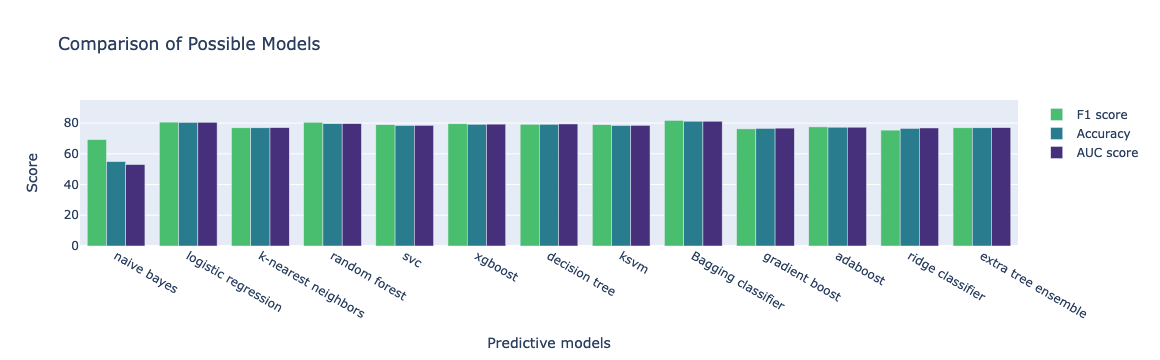

In [118]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score',range=[0,95],showgrid=True,scaleanchor = "x",scaleratio = 1), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

## Tuning the Logistic Classifier
Note: The gridsearch step is included here for completeness sake, as this is a smart inclusion in any iteration of possible models. But for the sake of speed (this notebook was run multiple times during development) I've kept my gridsearch to a bare-bones placeholder. A more complete project would use a broader grid.

In [104]:
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])

# Create grid search using 5-fold cross validation
grid_lr = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-pack

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'max_iter': [3000], 'penalty': ['l1', 'l2']})

In [105]:
print(grid_lr.best_params_)

log_model = grid_lr

{'C': 59.94842503189409, 'max_iter': 3000, 'penalty': 'l2'}


In [106]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.8062
Accuracy 0.8039
AUC Score 0.8049


In [35]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

## Final Model Metrics

In [107]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

{'precision': 0.832,
 'recall': 0.7819548872180451,
 'f1 score': 0.8062015503875969,
 'accuracy': 0.803921568627451,
 'error rate': 0.196078431372549,
 'ROC-AUC': 0.8049118698385308}

In [119]:

eval_scores_bg=model_metrics(y_test, Bagg_pred)
eval_scores_bg

{'precision': 0.8294573643410853,
 'recall': 0.8045112781954887,
 'f1 score': 0.816793893129771,
 'accuracy': 0.8117647058823529,
 'error rate': 0.18823529411764706,
 'ROC-AUC': 0.8120917046715148}

In [120]:
# Round the y values.
y_vals=[]
for val in list(eval_scores_bg.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
eval_scores=dict(zip(eval_scores_bg.keys(), y_vals))
print(eval_scores_bg)

{'precision': 0.8294573643410853, 'recall': 0.8045112781954887, 'f1 score': 0.816793893129771, 'accuracy': 0.8117647058823529, 'error rate': 0.18823529411764706, 'ROC-AUC': 0.8120917046715148}


In [121]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores_bg.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [122]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores_bg.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

{'precision': 82.9,
 'recall': 80.5,
 'f1 score': 81.7,
 'accuracy': 81.2,
 'error rate': 18.8,
 'ROC-AUC': 81.2}

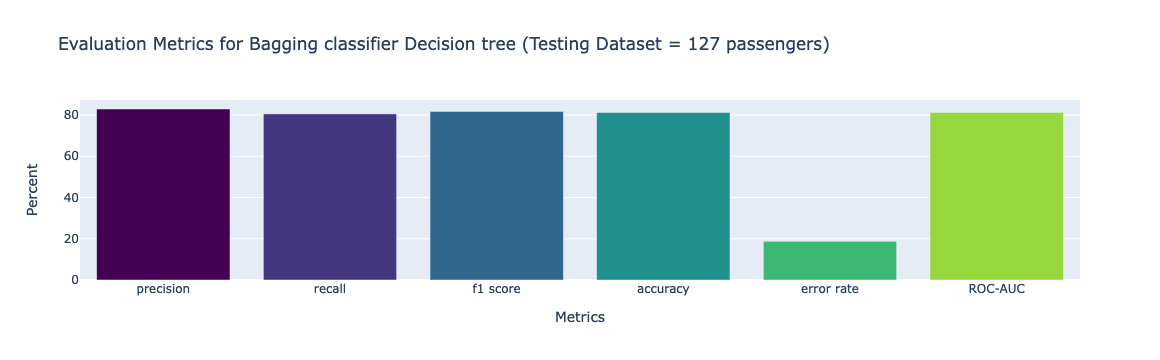

In [124]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for Bagging classifier Decision tree (Testing Dataset = 127 passengers)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [41]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

array([0.    , 0.    , 0.    , 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125, 0.025 , 0.025 , 0.025 , 0.025 , 0.0375, 0.0375,
       0.05  , 0.05  , 0.075 , 0.075 , 0.1125, 0.1375, 0.175 , 0.1875,
       0.1875, 0.2   , 0.2125, 0.275 , 0.275 , 0.2875, 0.325 , 0.3375,
       0.3625, 0.3625, 0.375 , 0.4   , 0.4125, 0.425 , 0.45  , 0.4625,
       0.525 , 0.525 , 0.5625, 0.5625, 0.575 , 0.6   , 0.75  , 0.7625,
       0.8   , 0.8125, 0.8125, 0.85  , 0.875 , 0.9   , 0.95  , 1.    ])

In [42]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

77.3

In [43]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [44]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict.json', 'w') as f:
    json.dump(roc_dict, f)

In [45]:
with open('resources/roc_dict.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [46]:
# # Save everything we need to reproduce the ROC-AUC figure in plotly dash.
# import json
# file = open('resources/FPR.json', 'wb')
# json.dump(FPR, file)
# file.close()

# file = open('resources/TPR.pkl', 'wb')
# pickle.dump(TPR, file)
# file.close()

# file = open('resources/y_test.pkl', 'wb')
# pickle.dump(y_test, file)
# file.close()

# file = open('resources/predictions.pkl', 'wb')
# pickle.dump(predictions, file)
# file.close()

In [47]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

{'data': [Scatter({
      'marker': {'color': '#46307c'},
      'mode': 'lines',
      'name': 'AUC: 77.3',
      'x': [0.0, 0.0, 0.0, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
            0.025, 0.025, 0.025, 0.025, 0.0375, 0.0375, 0.05, 0.05, 0.075, 0.075,
            0.1125, 0.1375, 0.175, 0.1875, 0.1875, 0.2, 0.2125, 0.275, 0.275, 0.2875,
            0.325, 0.3375, 0.3625, 0.3625, 0.375, 0.4, 0.4125, 0.425, 0.45, 0.4625,
            0.525, 0.525, 0.5625, 0.5625, 0.575, 0.6, 0.75, 0.7625, 0.8, 0.8125,
            0.8125, 0.85, 0.875, 0.9, 0.95, 1.0],
      'y': [0.0, 0.015873015873015872, 0.06349206349206349, 0.06349206349206349,
            0.07936507936507936, 0.12698412698412698, 0.25396825396825395,
            0.30158730158730157, 0.3333333333333333, 0.42857142857142855,
            0.4603174603174603, 0.49206349206349204, 0.5396825396825397,
            0.5714285714285714, 0.5873015873015873, 0.6031746031746031,
            0.6031746031746031, 0.6190476190476191,

In [48]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: survival', 'pred: death'])
cm[f'n={len(y_test)}']=['actual: survival', 'actual: death']
cm=cm[[f'n={len(y_test)}', 'pred: survival', 'pred: death']]
cm

[[69 11]
 [20 43]]


,n=143,pred: survival,pred: death
0,actual: survival,69,11
1,actual: death,20,43


In [49]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix.csv')
cm

,n=143,pred: survival,pred: death
0,actual: survival,69,11
1,actual: death,20,43


In [50]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: survival'], cm['pred: death']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix: Logistic Regression Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

{'data': [Table({
      'cells': {'align': [left, left, left, left, left],
                'fill': {'color': 'white'},
                'line': {'color': '#7D7F80'},
                'values': [['actual: survival', 'actual: death'], [69, 20], [11,
                           43]]},
      'header': {'align': [left, left, left, left, left],
                 'fill': {'color': '#6bcc5a'},
                 'line': {'color': '#7D7F80'},
                 'values': array(['n=143', 'pred: survival', 'pred: death'], dtype=object)}
  })],
 'layout': Layout({
     'title': {'text': 'Confusion Matrix: Logistic Regression Model (Testing Dataset)'}
 })}

In [51]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), logreg.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

,feature,coefficient
1,female,1.99
9,Mrs.,1.07
4,Cherbourg,0.35
10,Miss,0.32
11,VIP,0.16
5,Queenstown,-0.11
0,Siblings and Spouses,-0.26
6,"Age (20, 28]",-0.41
7,"Age (28, 38]",-0.43
8,"Age (38, 80]",-0.97


In [52]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients.csv', index=False)

In [53]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Married women in 1st class had better odds of survival, especially if younger than 38',
    xaxis = {'title': 'Passenger Features'},
    yaxis = {'title': 'Odds of Survival'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [54]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test1))

143
143
143
143


In [55]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['survival_prob'])

In [56]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Survived"},inplace=True)

In [57]:
final.shape

(143, 15)

In [58]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,0,1,0,1,0.938691
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,0,1,0,1,0,1,0.847526
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,0,1,0,0,0,0,0.276496
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,0,0,0,1,0,1,0.937265
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,0,0,0,0,0.231061


In [59]:
final.to_csv('resources/final_probs.csv', index=False)

In [60]:
list(final.columns)

['Name',
 'Siblings and Spouses',
 'female',
 'Cabin Class 2',
 'Cabin Class 3',
 'Cherbourg',
 'Queenstown',
 'Age (20, 28]',
 'Age (28, 38]',
 'Age (38, 80]',
 'Mrs.',
 'Miss',
 'VIP',
 'Survived',
 'survival_prob']

In [62]:
mydata=final.drop(['survival_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

[Table({
     'cells': {'values': ['Thayer, Mr. John Borland Jr', 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]},
     'header': {'values': [Name, Siblings and Spouses, female, Cabin Class 2, Cabin
                           Class 3, Cherbourg, Queenstown, Age (20, 28], Age (28,
                           38], Age (38, 80], Mrs., Miss, VIP, Survived]}
 })]

## Exploring individual predictions

In [63]:
value='Sharp, Mr. Percival James R'
survival=final.loc[3, 'survival_prob']
survival

0.9372653748980653

In [64]:
names=df['Name'].values
names[:5]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

In [65]:
indexs=df['Name'].index.values
indexs[:5]

array([0, 1, 2, 3, 4])

In [66]:
names=df['Name'].values
index=df['Name'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

(5, 'McCarthy, Mr. Timothy J')
5
McCarthy, Mr. Timothy J


In [67]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

{'label': 'Braund, Mr. Owen Harris', 'value': 0}

In [68]:
value=nameslist[0][0]
value

0

In [69]:
survival=final.loc[value, 'survival_prob']
round(survival*100)

94

In [70]:
final.columns

Index(['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2',
       'Cabin Class 3', 'Cherbourg', 'Queenstown', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP', 'Survived',
       'survival_prob'],
      dtype='object')

## Predict on a single, individual row of data.

In [71]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,0,1,0,1,0.938691
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,0,1,0,1,0,1,0.847526
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,0,1,0,0,0,0,0.276496
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,0,0,0,1,0,1,0.937265
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,0,0,0,0,0.231061


In [72]:
testset=final.drop(["survival_prob", 'Name','Survived'], axis=1)
firstrow=testset.loc[0]
firstrow

Siblings and Spouses    0
female                  1
Cabin Class 2           0
Cabin Class 3           0
Cherbourg               1
Queenstown              0
Age (20, 28]            1
Age (28, 38]            0
Age (38, 80]            0
Mrs.                    0
Miss                    1
VIP                     0
Name: 0, dtype: int64

In [73]:
myarray=firstrow.values
myarray.shape

(12,)

In [74]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

(1, 12)

In [75]:
logreg.predict_proba(thisarray)

array([[0.07385792, 0.92614208]])

In [76]:
logreg.predict(thisarray)

array([1])

In [77]:
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Last Name', 'First Name', 'Title',
       'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')